In [1]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import numpy as np

import time

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

## <font size="4"><b>Оглавление </b></p></font> 
<a id='contents'></a>

1. [Постановка задания](#intro)
2. [Обзор данных](#data_review)
- [Корреляция признаков](#data_review_correlation)
- [Проверка дубликатов](#data_review_dublicates)
- [Выводы](#data_review_summary)
3. [Сплит данных на выборки](#data_split)
- [Разделение и масштабирование](#split&scale)
- [Выводы](#data_split_summary)
4. [Построение моделей](#model_initialisation)
- [Линейная регрессия](#models_linier_regression)
- [Выводы](#model_initialisation_summary)
5. [Расчет прибыли и рисков](#profit&risk_calculation)
- [Подготовка к расчету](#calculation_preparation)
- [Расчет](#calculation)
- [Выводы](#profit&risk_calculation_summary)
6. [Итоги исследования](#summary)

<a id='intro'></a>

# **Выбор локации для скважины**

**Заказчик** — добывающая компания «ГлавРосГосНефть».

**Цель исследования**:
1. Построить систему, способную на основании предоставленных данных спрогнозировать, в каком регионе наиболее выгодно бурить новую скважину, а также оценить связанные с этим риски.

**Поставленные задачи**
1. Изучить предоставленные данные и подготовить их для обучения моделей. Разделить исходные данные на обучающую и валидационную выборки в соотношении 75:25.
2. Обучить и проверить модель для каждого региона. Предсказать объём запасов сырья в  скважинах и проанализировать RMSE модели.
3. Рассчитать достаточный объём сырья для безубыточной разработки новой скважины. Сравнить полученный объём сырья со средним запасом в каждом регионе.
4. Выбрать скважины с самыми высокими оценками значений и рассчитать прибыль для объёма сырья по выбранным скважинам.
5. Посчитать риски и прибыль для каждого региона с помощью техники Bootstrap с 1000 выборок и 95%-м доверительным интервалом.
6. Определить регион с максимальной суммарной прибылью отобранных скважин.

**Дальнейшее использование**

Результаты исследования будут использоваться в дальнейшем при планировании добывающей компанией объектов для инвестиции и развития своего бизнеса, а также для оценки итоговой прибыли и сопутствующих рисков при разработке выбранного региона. 

**Дополнительно предоставленная инфомарция и условия**

- Имеются исторические данные геологоразведки трёх регионов.
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

[К оглавлению](#contents)

<a id='data_review'></a>

## **I. Обзор данных**

### 1. Первичный обзор

В ходе исследования нам понадобятся библиотеки и модули:

* `pandas`
* `numpy`
* `time`
* `sklearn`:
    - `metrics`
    - `preprocessing`
    - `linear_model`    
    - `model_selection`

Сначала составим представление о полученных исходных данных.
Для этого используем библиотеку `pandas`.

Импортируем библиотеку и прочитаем файлы `geo_data_0.csv`, `geo_data_1.csv`, `geo_data_2.csv` из папки `/datasets/` и сохраним их в переменных `df_0`, `df_1`, `df_2`:

In [2]:
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
#сохраним все в единую пемеренную `data`:
datas = {
    'geo_data_0':[df_0],
    'geo_data_1':[df_1], 
    'geo_data_2':[df_2],
}

Выведем на экран первые пять строк таблиц:

In [4]:
for df in datas:
    print('\n\t\033[4m\033[1m\033[31m{}\033[0m'.format(df))
    display(datas.get(df)[0].head())
    print('_' * 50)


	geo_data_0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


__________________________________________________

	geo_data_1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


__________________________________________________

	geo_data_2


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


__________________________________________________


Получим общую информацию: <a id='df.info'></a>

In [5]:
for df in datas:
    print('\t\t\033[4m\033[1m\033[31m{}\033[0m'.format(df), '\n')
    display(datas.get(df)[0].info())
    print('*' * 50)

		geo_data_0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

**************************************************
		geo_data_1 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

**************************************************
		geo_data_2 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

**************************************************


Итак, в каждой таблице по 4 столбца. Типы данных в столбцах — вещественные числа `float` и строки `object`.

Согласно документации к данным:

* `id` — уникальный идентификатор скважины
* `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы)
* `product` — объём запасов в скважине (тыс. баррелей), это наш **целевой признак**.

Количество значений в столбцах соотнесены. Значит, в данных нет **пропущенных значений**.

Все данные представлены числовыми значениями, кроме столбца `id`, который мы в последующем удалим за ненадобностью при обучении модели.

[К оглавлению](#contents)

<a id='data_review_correlation'></a>

### 2. Корреляция

Посмотрим на распределение признаков, от которых будет зависеть наш целевой признак. Исключим сразу профильные данные: уникальный номер скважины.

In [6]:
# функция для выведения графиков распределения
def correlation (data):
    features_correlation = list(set(datas.get(data)[0].columns) - set(['id', 'product']))
    print('\t\t\033[4m\033[1m\033[31m{}\033[0m'.format(data), '\n')
    datas.get(data)[0][features_correlation].hist(figsize=(20,12))
    print('*' * 50)
    
# функция построения таблицы корреляционных значений
def correlation_table (data):
    print('\t\t\033[4m\033[1m\033[31m{}\033[0m'.format(data), '\n')
    display(datas.get(data)[0].corr())
    print('*' * 50)

		geo_data_0 

**************************************************


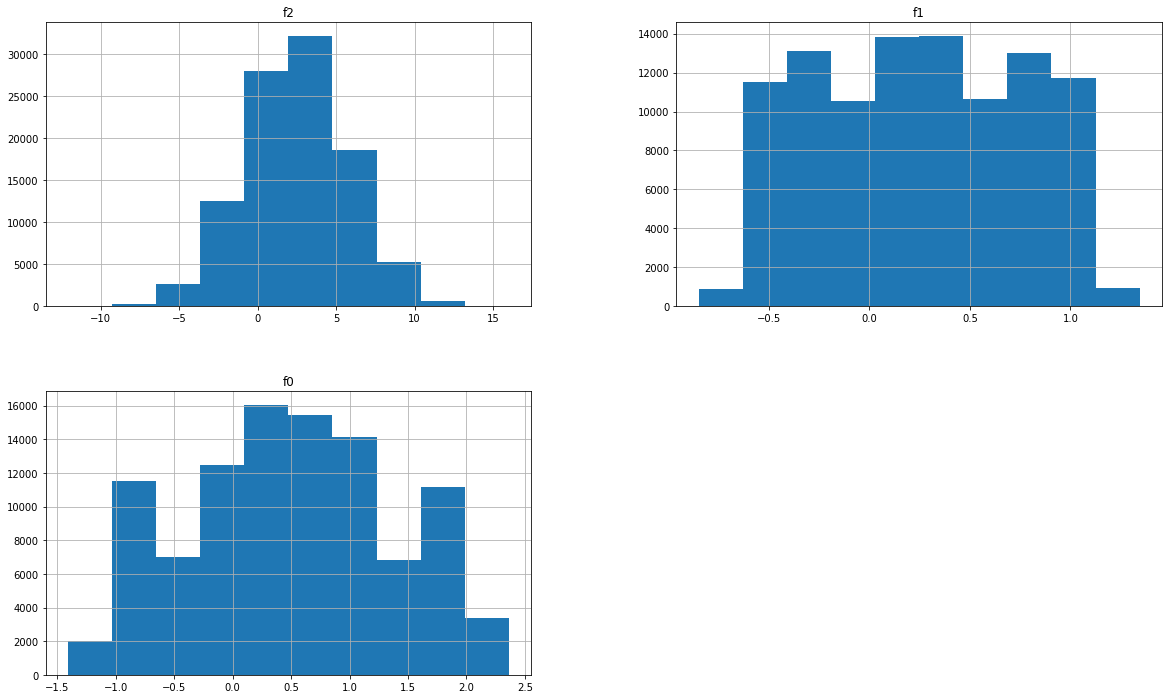

In [7]:
correlation('geo_data_0')

Видим, что в первом месторождениии только признак `f2` распределен нормально. У признаков `f0` и `f1` имеются ненормальные пики либо большой разброс значений признака при примерно одинаковом распределении.

In [8]:
correlation_table('geo_data_0')

		geo_data_0 



,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


**************************************************


Влиятние признаков `f0` и `f2` прямо пропорциональное, однако у признака `f2` оно самое большое, значит данный признак будет иметь больший вес. Вес признаков `f0` и `f1` примерно одинаков хоть и разнонаправлен. Наблюдается незначительная мультиколлинеарность признаков `f1` и `f0` между собой, что может негативно сказаться на обучаемой модели и интерпретировании результотов предсказаний.

		geo_data_1 

**************************************************


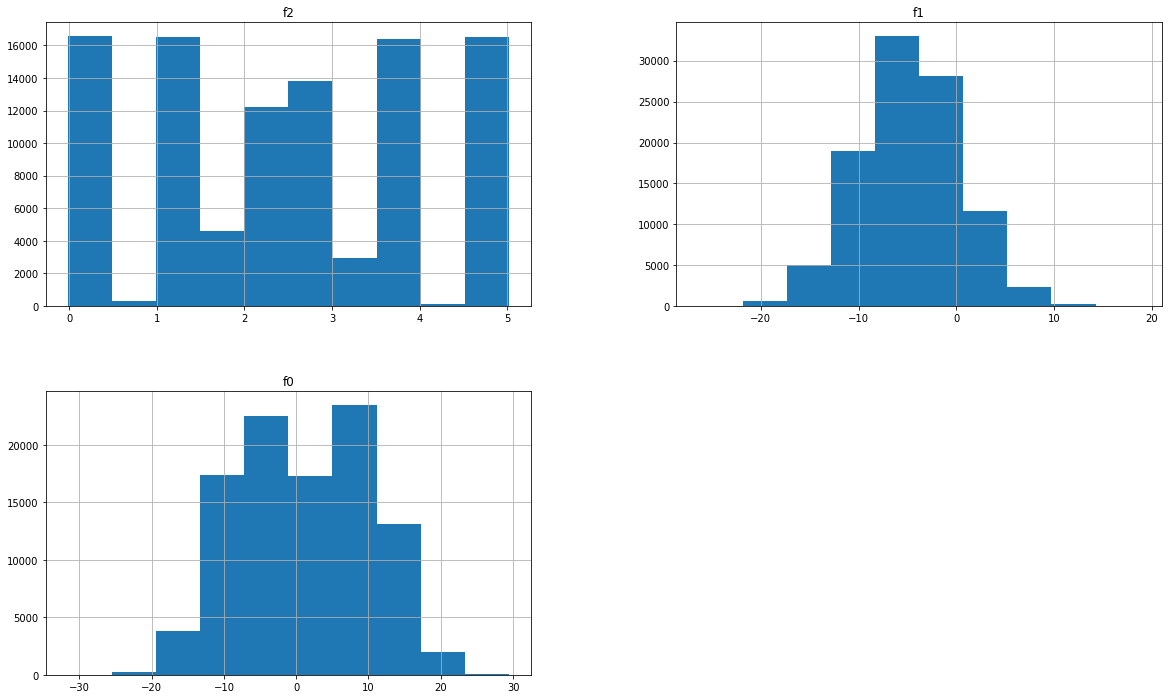

In [9]:
correlation('geo_data_1')

Для второго региона, что ситуация примерно такая же, только только признак f1 распределен нормально. У признаков f0 и f2 имеются ненормальные пики либо большой разброс значений признака при примерно одинаковом распределении.

In [10]:
correlation_table('geo_data_1')

		geo_data_1 



,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


**************************************************


Также для второго региона видим прямую зависимость от признака `f2`, который будет оказывать основное влияние на предсказание, и практически нулевую от других. Значит в этом регионе `f2` играет ключевую роль. Мультиколлинеарности признаков между собой не наблюдаю.

		geo_data_2 

**************************************************


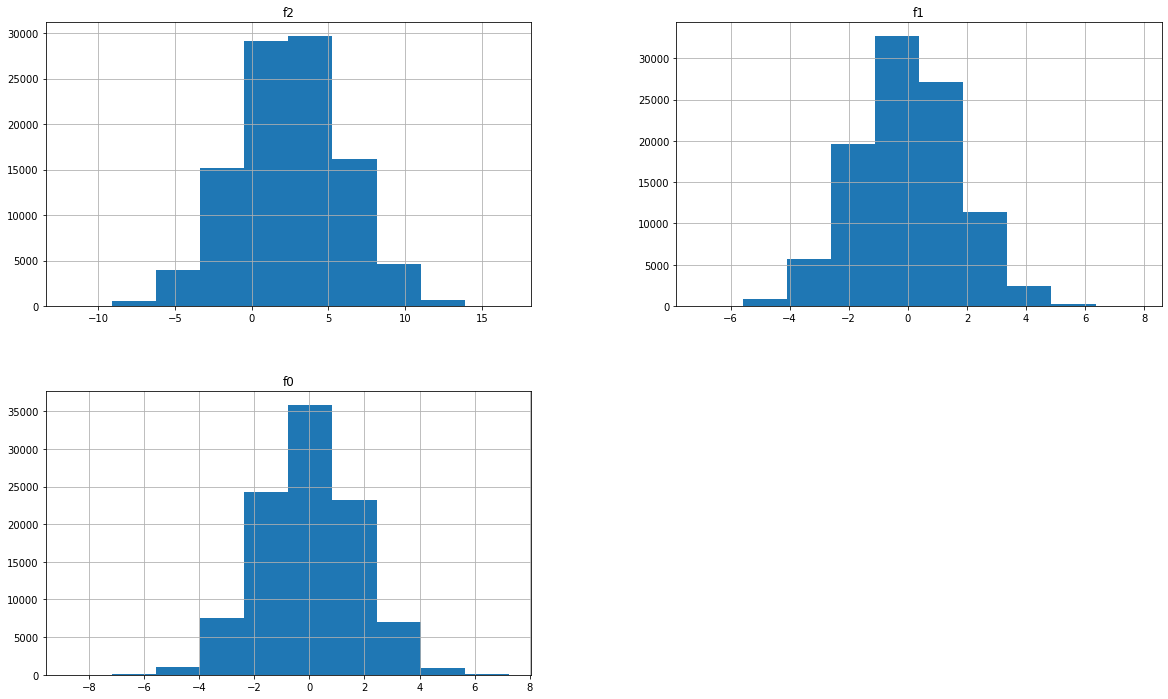

In [11]:
correlation('geo_data_2')

В третьем регионе наблюдается самая лучшая картина по распределению - все признаки распределены нормально.

In [12]:
correlation_table('geo_data_2')

		geo_data_2 



,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


**************************************************


Влияние всех признаков `f0` и `f1` на объем запасов сырья примерно одинаковый, а вот `f2` как и в других регионах является ключевым. Мультиколлинеарности признаков между собой нет.



[К оглавлению](#contents)

<a id='data_review_dublicates'></a>

### 3. Проверка дубликатов

Выполним проверку явных дубликатов для датасетов

In [13]:
for df in datas:
    print(f'Дубликатов в \033[4m\033[1m\033[31m{df}\033[0m:', datas.get(df)[0].duplicated().sum())
    print('-' * 25)

Дубликатов в geo_data_0: 0
-------------------------
Дубликатов в geo_data_1: 0
-------------------------
Дубликатов в geo_data_2: 0
-------------------------


И неявных дубликатов одних и тех же скважин

In [14]:
for df in datas:
    print(f'Дубликатов скважин в \033[4m\033[1m\033[31m{df}\033[0m:', datas.get(df)[0]['id'].duplicated().sum())
    print('-' * 25)

Дубликатов скважин в geo_data_0: 10
-------------------------
Дубликатов скважин в geo_data_1: 4
-------------------------
Дубликатов скважин в geo_data_2: 4
-------------------------


Как мы видим в данных имеются записи об одних и тех же скважинах в регионах, отличающихся между собой значениями признаков `f0-f2`. Рекомендуется сообщить об этом специалистам по сбору и обработке информации для базы данных, чтобы почистили данные и определили ее первопричину.

<a id='data_review_summary'></a>

### **Выводы**

- Каждый объект в наборе данных — данные об уникальной скважине (с условием исключения повторяющихся записей с отличающимися значениями признаков). 
- ключевым признаком, оказывающим основное влияние на целевой признак (объем сырья в скважине), является `f2`
- самым удачным датасетом для обучения модели является третий регион geo_data_2, в котором все признаки распределены нормально и нет мультиколлинеарности признаков между собой. В других датасетах данные сильно загрязнены и будут негативно сказываться на обучаемой модели и интерпретировании результотов предсказаний.

[К оглавлению](#contents)

<a id='data_split'></a>

## **II. Сплит данных на выборки**

Удалим из данных, признаки не оказывающие никакого влияния на ответ на интересующий нас вопрос, а именно:
- уникальный номер скважины

In [15]:
for df in datas:
    df_new = datas.get(df)[0].drop(columns = ['id'],axis = 1)
    datas.update({df:[df_new]})

<a id='split&scale'></a>

### 1. Разделение и масштабирование

Предоставленные данные представляют собой единые датафреймы, разделения на обучающую и валидационную выборки у нас сейчас нет. Поэтому выполним это сейчас с помощью алгоритма `train_test_split` в соотношении 3:1.

Помимо этого все признаки представлены числовыми значениями, поэтому на всякий случай смасштабируем их между собой, чтобы избежать негативного влияния на наши модели.

Для этого напишем функцию, принимающую на вход исходный датафрейм и целевой признак, а на выходе получаем разделенные и смасштабированные выборки.

In [16]:
# ФУНКЦИЯ ПОДГОТОВКИ ДАННЫХ К ОБУЧЕНИЮ

def data_split_and_scale (data, target_attribute):
    
    # РАЗДЕЛЕНИЕ НА ВЫБОРКИ
    
    # разделение на целевой признак и другие признаки
    features = datas.get(data)[0].drop([target_attribute], axis=1)
    target = datas.get(data)[0][target_attribute]
    
    # разделение на тренировочную и валидационную выборки, размер фракции возьмем 25% по условию задания
    features_train, features_valid, target_train, target_valid = (train_test_split
                                                                  (features, target, 
                                                                   test_size=.25, 
                                                                   random_state=12345)
                                                                 )
    
    # ПРОВЕРКА РАЗМЕРОВ ВЫБОРОК
    
    # добавим все выборки в словарь
    arrays = {
        'Обучающая' : features_train,
        'Валидационная' : features_valid}
    
    # выведем количество содержащихся объектов
    print("\033[4m\033[1m\033[31m{}\033[0m\n".format(f'ИСХОДНЫЕ ДАННЫЕ {data}:'))
    for array_name, array in arrays.items():
        print(
            "\033[4m\033[1m\033[31m{}\033[0m содержит объектов:".format(f'{array_name} выборка'), 
            array.shape[0], 
            f'({array.shape[0] / datas.get(data)[0].shape[0]:.1%})'
        )

    # МАСШТАБИРОВАНИЕ
    
    # создадим объект масштабирования, скормим ему тренировочную выборку количественных признаков 
    # для определения и преобразуем обучающую и валидационную выборки функцией `transform()`
    numeric = ['f0', 'f1', 'f2']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric]) 

    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])

    return features_train, features_valid, target_train, target_valid

На примере первого региона `geo_data_0` проверим правильность выполнения функции по разбиению данных на выборки

In [17]:
features_train, features_valid, target_train, target_valid = data_split_and_scale ('geo_data_0','product')

ИСХОДНЫЕ ДАННЫЕ geo_data_0:

Обучающая выборка содержит объектов: 75000 (75.0%)
Валидационная выборка содержит объектов: 25000 (25.0%)


<a id='data_split_summary'></a>

### **Выводы**

Получили равные выборки в отношении 3:1, которые будем использовать уже для создания наших моделей по регионам. Так как в исследовании необходимым целевым признаком является количественный параметр (нужно ответить предсказать, сколько ожидается объем сырья в скважине), следовательно будем использовать модель через регрессию. Согласно условию задания моделью выбрана **«Линейная регрессия»**

[К оглавлению](#contents)

<a id='model_initialisation'></a>

## **III. Построение и проверка моделей**

<a id='models_linier_regression'></a>

### 1. Модель «Линейная регрессия»

Напишем функцию для построения модели `«Линейная регрессия»` на основании создаваемых выборок тренировочной и валидационной. Будем сохранять предсказания и правильные ответы на валидационной выборке. 

Оценивать модель будем через `средний запас предсказанного сырья` и `RMSE` модели. 

In [18]:
# ФУКНЦИЯ ЛИНЕЙНОЙ РЕГРЕССИИ на основе предыдущей функции деления на выборки

def model_linear_regression (data, target_attribute):
    
    # выполнение функции разделения и масштабирования
    features_train, features_valid, target_train, target_valid = data_split_and_scale (data, target_attribute)

    # засекаем время
    start_time = time.time()
    
    # создаем модельку
    model = LinearRegression()
    # кормим ей валидационную выбоку
    model.fit(features_train, target_train)
    
    # делаем предсказание и смотрим на качество опреления целевого признака
    predictions = model.predict(features_valid)
    model_time = round((time.time() - start_time), 5)
    rmse = round(mean_squared_error(target_valid, predictions) ** .5, 2)
    predictions_product_average = round(predictions.mean(), 1)
    target_product_average = round(target_valid.mean(), 1)
    
    # вывод на экран
    print("\033[4m\033[1m\033[31m{}\033[0m {}".format('Cредний запас предсказанного сырья равен:', 
                                                      f'{predictions_product_average:.1f} тыс. баррелей'))
    
    print("\033[4m\033[1m\033[31m{}\033[0m {}".format('Cредний запас реального сырья равен:', 
                                                      f'{target_product_average:.1f} тыс. баррелей'))
    
    print("\033[4m\033[1m\033[31m{}\033[0m {}".format('Средняя ошибка RMSE равна:', f'{rmse:.2f}'))
    
    print("\033[4m\033[1m\033[31m{}\033[0m {}".format('Время обучения равно:', f'{model_time:.5f} секунд'))
    
    print('-' * 70)
    
    return predictions, target_valid, model_time, rmse, predictions_product_average, target_product_average

Далее сделаем вывод интересующей нас информации для всех трех регионов

In [19]:
regions = []

for df in datas:
    # для срабатывания функции `model_linear_regression` сразу зададим входные параметры
    target_attribute = 'product'
    data = df
    
    # извлекаем переменные из функции `model_linear_regression` и вносим с список `regions`
    predictions, target_valid, model_time, rmse, predictions_product_average, target_product_average = model_linear_regression (data,target_attribute)
    regions.extend([[df, model_time, rmse, predictions_product_average, target_product_average]])
    
    # добавление предсказаний и правильных ответов в словарь
    do = datas.get(df)[0]
    predictions = pd.Series(predictions).reset_index(drop=True)
    target_valid = pd.Series(target_valid).reset_index(drop=True)
    datas[df] = [do, target_valid, predictions]
    
# задаем названия колонок для готовящейся сводной таблицы
columns = ['Регион', 'Время обучения', 'RMSE', 'Cредний запас предсказанного сырья, тыс. баррелей', 
           'Cредний запас реального сырья, тыс. баррелей']

# оформляем результаты в виде таблицы
summary = pd.DataFrame(data=regions, columns=columns)

ИСХОДНЫЕ ДАННЫЕ geo_data_0:

Обучающая выборка содержит объектов: 75000 (75.0%)
Валидационная выборка содержит объектов: 25000 (25.0%)
Cредний запас предсказанного сырья равен: 92.6 тыс. баррелей
Cредний запас реального сырья равен: 92.1 тыс. баррелей
Средняя ошибка RMSE равна: 37.58
Время обучения равно: 0.00762 секунд
----------------------------------------------------------------------
ИСХОДНЫЕ ДАННЫЕ geo_data_1:

Обучающая выборка содержит объектов: 75000 (75.0%)
Валидационная выборка содержит объектов: 25000 (25.0%)
Cредний запас предсказанного сырья равен: 68.7 тыс. баррелей
Cредний запас реального сырья равен: 68.7 тыс. баррелей
Средняя ошибка RMSE равна: 0.89
Время обучения равно: 0.00664 секунд
----------------------------------------------------------------------
ИСХОДНЫЕ ДАННЫЕ geo_data_2:

Обучающая выборка содержит объектов: 75000 (75.0%)
Валидационная выборка содержит объектов: 25000 (25.0%)
Cредний запас предсказанного сырья равен: 95.0 тыс. баррелей
Cредний запас реаль

In [20]:
summary

,Регион,Время обучения,RMSE,"Cредний запас предсказанного сырья, тыс. баррелей","Cредний запас реального сырья, тыс. баррелей"
0,geo_data_0,0.00762,37.58,92.6,92.1
1,geo_data_1,0.00664,0.89,68.7,68.7
2,geo_data_2,0.00709,40.03,95.0,94.9


<a id='model_initialisation_summary'></a> 

###  **Выводы**

По итогу создания моделей мы видим:
- В масштабах регионов модель на основе алгоритма «Линейная регрессия» верно предсказывает средние запасы добываемого сырья с лучшим показателем средней ошибки `RMSE равным 0.89` (`для второго региона geo_data_1`) и достаточно быстрой скоростью обучения в районе `0.01 секунды`. 

**Однако не стоит забывать, что гистограммы распределения признаков показали худшую подготовленность данных именно этого региона с высокой долей зависимости от признака `f2` в почти 99,9% и ненормальным распределением.** Фактически запас сырья моделью для данного региона определялся только этим признаком. Поэтому не считаю правильным использовать модель №2.
- Помимо этого во втором регионе заметно меньше средний запас сырья, следовательно и потенциальная прибыль будет ниже.

[К оглавлению](#contents)

<a id='profit&risk_calculation'></a>

## **IV. Расчёт прибыли**

<a id='calculation_preparation'></a>

### 1. Подготовка к расчету

Необходимо: 
- рассчитать достаточный объём сырья для безубыточной разработки новой скважины;
- сравнить полученный объём сырья со средним запасом в каждом регионе.

Из дополнительно предоставленной инфомарции и по условиям задания имеем:
- вероятность убытков должна быть меньше 2.5%

In [21]:
SCOUTING_POINTS = 500             # шт., количество точек разведки
DEVELOPED_POINTS = 200            # шт., количество выбираемых точек для разработки
BUDGET = 10 ** 7                  # тыс. рублей, бюджет на разработку скважин на один регион
PROFIT_PER_SELL_BARREL_UNIT = 450 # тыс. рублей за 1 тыс баррелей, доход с каждой единицы продукта

Для начала необходимо определить достаточный объем сырья для безубыточной разработки. На 200 точек для разработки выделяется 10 млрд. рублей, следовательно для безубыточности разработки одной скважины она в среднем должна приносить:

In [22]:
product_average_per_point = BUDGET / DEVELOPED_POINTS / PROFIT_PER_SELL_BARREL_UNIT

print(f'Средний объем сырья со скважины должен быть не ниже {product_average_per_point:.2f} тыс. баррелей')

Средний объем сырья со скважины должен быть не ниже 111.11 тыс. баррелей


А в действительности одна скважина в каждом регионе в среднем содержит сырья:

In [23]:
for df in datas:
    mean = datas.get(df)[0]['product'].mean()
    print(f'В регионе {df} в среднем в каждой скважине содержится {mean:.2f} тыс. баррелей')

В регионе geo_data_0 в среднем в каждой скважине содержится 92.50 тыс. баррелей
В регионе geo_data_1 в среднем в каждой скважине содержится 68.83 тыс. баррелей
В регионе geo_data_2 в среднем в каждой скважине содержится 95.00 тыс. баррелей


Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [24]:
# ФУНКЦИЯ ПОДСЧЕТА ПРИБЫЛИ
def profit_function(target, probabilities, count):
    
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    # поступления
    income = PROFIT_PER_SELL_BARREL_UNIT * selected.sum()
    # чистая прибыль с вычитом вложенных в разработку средств
    profit = income - BUDGET
    
    return profit 

[К оглавлению](#contents)

<a id='calculation'></a>

### 2. Проведение расчета рисков и прибыли для каждого региона

Процедурой бутстреп найдем 95%-й доверительный интервал

In [25]:
# зададим значение сменяющегося рандома для исключения повторения значений 
state = np.random.RandomState(123456)

# ФУНКЦИЯ РАСЧЕТА ДОВЕРИТЕЛЬНОГО ИНТЕРВАЛА И СРЕДНЕЙ ПРИБЫЛИ на основе функции прибыли
def bootstrap (data, target, probs, SAMPLE, INTERVAL):
    
    # расчет прибыли
    values = []
    
    for i in range(SAMPLE):
        target_subsample = target.sample(n=SCOUTING_POINTS, replace=True, random_state=state)
        probs_subsample = probs[target_subsample.index]
        values.append(profit_function(target_subsample, probs_subsample, DEVELOPED_POINTS))
    
    values = pd.Series(values)
    
    # вычисление квантилей по условию
    quantile = (1 - INTERVAL) / 2
    lower = round(values.quantile(0 + quantile) / 1000, 2)
    upper = round(values.quantile(1 - quantile) / 1000, 2)
    
    # средняя прибыль и риски
    mean = round(values.mean() / 1000, 2)
    fails = (values < 0).sum()
    risk = fails / SAMPLE
    
    #выводим на экран всю информацию
    print("\033[4m\033[1m\033[31m{}\033[0m\n".format(f'ИСХОДНЫЕ ДАННЫЕ {data}:'))
    print(f'Средняя выручка: {mean} млн. руб')
    print(f'95% доверительный интервал от {lower:.2f} до {upper:.2f} млн.руб.')
    print(f'Риски: {risk:.2%}')
    print('Количество убыточных случаев:', fails)
    print('-' * 70)
    
    return mean, lower, upper, risk, fails, quantile

Далее сделаем вывод интересующей нас информации для всех трех регионов

In [26]:
# Можно поиграться с количеством выборок и доверительным интервалом, чтобы увидеть, 
# что несмотря на финальные значения при 95%-м доверительном интервале, 
# второй регион не является самым безопасным для вложения, так как риск там самый большой, 
# хоть и разброс потенциальной прибыли больше

SAMPLE = 1000
INTERVAL = .95

In [27]:
regions_1 = []

for df in datas:
    # для срабатывания функции `bootstrap` сразу зададим входные параметры
    target = datas.get(df)[1]
    probs = datas.get(df)[2]
    
    # извлекаем переменные из функции `bootstrap` и вносим с список `regions`
    mean, lower, upper, risk, fails, quantile = bootstrap (df, target, probs, SAMPLE, INTERVAL)
    risk = risk * 100
    regions_1.extend([[df, mean, lower, upper, risk]])
    
# задаем названия колонок для готовящейся сводной таблицы
columns_1 = ['Регион', 'Средняя выручка, млн. руб', f'{round(0 + quantile, 3)}-квантиль, млн. руб', 
             f'{round(1 - quantile, 3)}-квантиль, млн. руб', 'Риски, %']

# оформляем результаты в виде таблицы
summary_1 = pd.DataFrame(data=regions_1, columns=columns_1)

ИСХОДНЫЕ ДАННЫЕ geo_data_0:

Средняя выручка: 442.01 млн. руб
95% доверительный интервал от -99.96 до 969.18 млн.руб.
Риски: 5.60%
Количество убыточных случаев: 56
----------------------------------------------------------------------
ИСХОДНЫЕ ДАННЫЕ geo_data_1:

Средняя выручка: 523.44 млн. руб
95% доверительный интервал от 134.46 до 945.71 млн.руб.
Риски: 0.70%
Количество убыточных случаев: 7
----------------------------------------------------------------------
ИСХОДНЫЕ ДАННЫЕ geo_data_2:

Средняя выручка: 421.15 млн. руб
95% доверительный интервал от -121.37 до 948.93 млн.руб.
Риски: 6.10%
Количество убыточных случаев: 61
----------------------------------------------------------------------


In [28]:
summary_1

,Регион,"Средняя выручка, млн. руб","0.025-квантиль, млн. руб","0.975-квантиль, млн. руб","Риски, %"
0,geo_data_0,442.01,-99.96,969.18,5.6
1,geo_data_1,523.44,134.46,945.71,0.7
2,geo_data_2,421.15,-121.37,948.93,6.1


In [29]:
summary_final = pd.concat([summary,summary_1.drop(columns = ['Регион'],axis = 1)],sort=False,axis=1)

In [30]:
summary_final

,Регион,Время обучения,RMSE,"Cредний запас предсказанного сырья, тыс. баррелей","Cредний запас реального сырья, тыс. баррелей","Средняя выручка, млн. руб","0.025-квантиль, млн. руб","0.975-квантиль, млн. руб","Риски, %"
0,geo_data_0,0.00762,37.58,92.6,92.1,442.01,-99.96,969.18,5.6
1,geo_data_1,0.00664,0.89,68.7,68.7,523.44,134.46,945.71,0.7
2,geo_data_2,0.00709,40.03,95.0,94.9,421.15,-121.37,948.93,6.1


<a id='profit&risk_calculation_summary'></a>

### 3. **Выводы**

По итогу создания моделей для разных регионов мы видим:
- у **второго региона** самая высокая средняя потенциальная выручка и самый низкий показатель **риска ~1%** с более низким **средним запасом сырья в одной скважине равным 68.7 тыс. баррелей**, а лучший показатель разброса прибыли - **почти любом исходе можно заработать больше инвестированных изначально средств**, в других же регионах есть шанс уйти в минус. 
- помимо вышеописанного, при обзоре данных **второй регион показался мне самым странным** и как будто синтетическим в сравнении с другими. Ну или он просто такой особенный, где ключевой признак `f2` напрямую показывает наглядно сколько мы добудем сырья.

[К оглавлению](#contents)

<a id='summary'></a>

## **V. Итоги исследования**

На основании предоставленных данных мы создали несколько моделей для определения предполагаемого объема по заданным признакам, расчитали потенциальную прибыль и вероятность убытка в каждом регионе и сделали выбор региона для дальнейшей разработки и инвестиций компании. И вот что у нас получилось:

In [31]:
summary_final

,Регион,Время обучения,RMSE,"Cредний запас предсказанного сырья, тыс. баррелей","Cредний запас реального сырья, тыс. баррелей","Средняя выручка, млн. руб","0.025-квантиль, млн. руб","0.975-квантиль, млн. руб","Риски, %"
0,geo_data_0,0.00762,37.58,92.6,92.1,442.01,-99.96,969.18,5.6
1,geo_data_1,0.00664,0.89,68.7,68.7,523.44,134.46,945.71,0.7
2,geo_data_2,0.00709,40.03,95.0,94.9,421.15,-121.37,948.93,6.1


**Лучшим регионом на основании данных (среди трех рассмотренных) для решения дальнейшей разработки является второй (`geo_data_1`).**

[К оглавлению](#contents)